# Influence functions for Large Language Models

## Imports

In [72]:
from datasets import load_dataset
import torch
from typing import Sequence
from pydvl.influence.torch import EkfacInfluence
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from copy import deepcopy
from IPython.display import HTML, display

## Sentiment Analysis

In [2]:
imdb = load_dataset("imdb")

small_train_dataset = (
    imdb["train"].shuffle(seed=42).select([i for i in list(range(10))])
)
small_test_dataset = imdb["test"].shuffle(seed=4).select([i for i in list(range(5))])

Found cached dataset imdb (/Users/fabio/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
100%|██████████| 3/3 [00:00<00:00, 428.63it/s]
Loading cached shuffled indices for dataset at /Users/fabio/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-9c48ce5d173413c7.arrow
Loading cached shuffled indices for dataset at /Users/fabio/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-d00218895ddb9236.arrow


In [3]:
tokenizer = AutoTokenizer.from_pretrained("assemblyai/distilbert-base-uncased-sst2")
model = AutoModelForSequenceClassification.from_pretrained(
    "assemblyai/distilbert-base-uncased-sst2"
)

In [4]:
tokenized_segments = tokenizer(
    ["Pydvl is the best data valuation library, and it is fully open-source!"],
    return_tensors="pt",
    padding=True,
    truncation=True,
)
tokenized_segments_input_ids, tokenized_segments_attention_mask = (
    tokenized_segments.input_ids,
    tokenized_segments.attention_mask,
)
model_predictions = F.softmax(
    model(
        input_ids=tokenized_segments_input_ids,
        attention_mask=tokenized_segments_attention_mask,
    )["logits"],
    dim=1,
)

print("Positive probability: " + str(model_predictions[0][1].item() * 100) + "%")
print("Negative probability: " + str(model_predictions[0][0].item() * 100) + "%")

Positive probability: 99.57591891288757%
Negative probability: 0.42408257722854614%


## Model and Data Preparation

In [76]:
class ImdbDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.tokenized_ds = dataset.map(self.preprocess_function, batched=True)
        self.encodings = self.tokenized_ds["input_ids"]
        self.attn_mask = self.tokenized_ds["attention_mask"]
        self.labels = self.tokenized_ds["label"]

    def preprocess_function(self, examples):
        return tokenizer(examples["text"], truncation=True, padding=True)

    def __getitem__(self, idx):
        x = torch.tensor([self.encodings[idx], self.attn_mask[idx]])
        y = torch.tensor(self.labels[idx])
        text = self.tokenized_ds[idx]["text"]
        return x, y, text

    def __len__(self):
        return len(self.labels)


class ModelLogitsWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x[:, 0], x[:, 1])["logits"]


def print_sentiment_preds(model: ModelLogitsWrapper, model_input: torch.Tensor):
    model_predictions = F.softmax(model(model_input.unsqueeze(0)), dim=1)
    print("Positive probability: " + str(model_predictions[0][1].item() * 100) + "%")
    print("Negative probability: " + str(model_predictions[0][0].item() * 100) + "%")


def strip_param_names(param_names: Sequence[str]):
    stripped_param_names = []
    for name in param_names:
        name = name.replace("model.", "")
        if name.startswith("distilbert.transformer."):
            name = name.replace("distilbert.transformer.", "")
        stripped_param_names.append(name)
    return stripped_param_names

In [69]:
for param in model.named_parameters():
    param[1].requires_grad = False

for m_name, module in model.named_modules():
    if len(list(module.children())) == 0 and len(list(module.parameters())) > 0:
        if isinstance(module, torch.nn.Linear):
            for p_name, param in module.named_parameters():
                if (
                    "ffn" in m_name
                    or "pre_classifier" in m_name
                    or "classifier" in m_name
                ):
                    param.requires_grad = True

In [61]:
total_params = sum(p.numel() for p in model.parameters()) / 1e6
params_requiring_grad = (
    sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
)

print("Total parameters: {:.2f} millions".format(total_params))
print("Parameters requiring gradients: {:.2f} millions".format(params_requiring_grad))
print("Ratio: {:.2f}%".format((params_requiring_grad / total_params) * 100))

Total parameters: 66.96 millions
Parameters requiring gradients: 28.93 millions
Ratio: 43.20%


## Influence function computation

In [62]:
train_dataset = ImdbDataset(small_train_dataset)
test_dataset = ImdbDataset(small_test_dataset)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=5, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=3, shuffle=True)

Loading cached processed dataset at /Users/fabio/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-2be1c3a446bd7743.arrow
Loading cached processed dataset at /Users/fabio/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-b0ad78d634cd6710.arrow


In [63]:
model_logits = ModelLogitsWrapper(model)
model_logits.eval()

ekfac_influence_model = EkfacInfluence(
    model_logits,
    progress=True,
)
ekfac_influence_model = ekfac_influence_model.fit(train_dataloader)

K-FAC blocks: 100%|██████████| 2/2 [00:14<00:00,  7.43s/it]


In [65]:
ekfac_influence_model.hessian_regularization = 1e-5

In [11]:
test_input, test_labels, test_text = next(iter(test_dataloader))
train_input, train_labels, train_text = next(iter(train_dataloader))

In [12]:
modified_train_labels = deepcopy(train_labels)
modified_train_labels[0] = 1 - train_labels[0]

In [13]:
ekfac_train_influences = ekfac_influence_model.influences(
    test_input,
    test_labels,
    train_input,
    modified_train_labels,
)

/Users/fabio/miniconda3/envs/pydvl_env/lib/python3.9/site-packages/transformers/models/distilbert/modeling_distilbert.py:222: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::masked_fill.Tensor. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:84.)
  scores = scores.masked_fill(


## Analysis of influence values

In [14]:
torch.mean(ekfac_train_influences, axis=0)

tensor([-4367.9858,  1003.2576,   751.8049,  -403.0711,    79.2274])

In [15]:
ekfac_train_influences

tensor([[-2.5754e+03,  3.5468e+02,  1.4799e+02, -1.9528e+02,  3.2583e+01],
        [-1.1582e+00, -4.7990e+01, -2.4654e+01,  1.5628e+01, -8.8081e-01],
        [-1.0527e+04,  2.7031e+03,  2.1321e+03, -1.0296e+03,  2.0598e+02]])

In [16]:
train_sentence_idx = 3
display(HTML(train_text[train_sentence_idx].split("<br />")[0]))
display(HTML(train_text[train_sentence_idx].split("<br />")[-1]))

In [17]:
test_sentence_idx = 2
display(HTML(test_text[test_sentence_idx].split("<br />")[0]))

In [18]:
print_sentiment_preds(model_logits, train_input[train_sentence_idx])

Positive probability: 14.639034867286682%
Negative probability: 85.36096215248108%


## Influence functions by layer

In [66]:
ekfac_train_influences = ekfac_influence_model.influences_by_layer(
    test_input,
    test_labels,
    train_input,
    modified_train_labels,
)

/Users/fabio/miniconda3/envs/pydvl_env/lib/python3.9/site-packages/transformers/models/distilbert/modeling_distilbert.py:222: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::masked_fill.Tensor. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:84.)
  scores = scores.masked_fill(


In [79]:
influences = torch.zeros(size=(3, 5))
for layer_id, value in ekfac_train_influences.items():
    influences += value

In [21]:
idx = (0, 2)
infl_across_layers = []
for layer_id, value in ekfac_train_influences.items():
    infl_across_layers.append(value[idx].item())

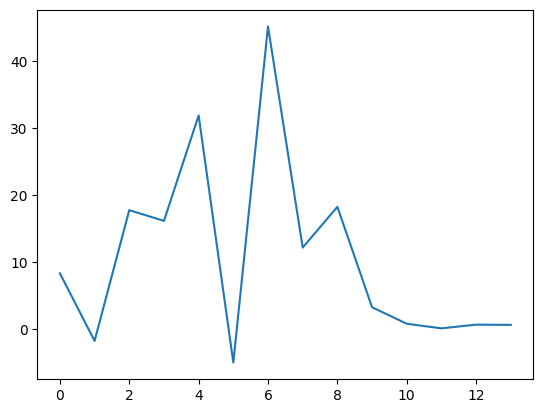

In [22]:
import matplotlib.pyplot as plt

plt.plot(infl_across_layers)

# Appendix

### Choosing the Hessian regularization value

In [23]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr

In [24]:
model_logits = ModelLogitsWrapper(model)
model_logits.eval()

ekfac_influence_model = EkfacInfluence(
    model_logits,
    progress=True,
)
ekfac_influence_model = ekfac_influence_model.fit(train_dataloader)

K-FAC blocks: 100%|██████████| 2/2 [00:11<00:00,  5.78s/it]


In [25]:
first_train_batch = next(iter(train_dataloader))

In [26]:
influences_by_reg_value = ekfac_influence_model.explore_hessian_regularization(
    first_train_batch[0],
    first_train_batch[1],
    regularization_values=[1e-9, 1e-7, 1e-5, 100],
)

/Users/fabio/miniconda3/envs/pydvl_env/lib/python3.9/site-packages/transformers/models/distilbert/modeling_distilbert.py:222: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::masked_fill.Tensor. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:84.)
  scores = scores.masked_fill(


In [27]:
cols = ["reg_value", "layer_id", "mean_infl"]
infl_df = pd.DataFrame(influences_by_reg_value, columns=cols)
for reg_value in influences_by_reg_value:
    for layer_id, layer_influences in influences_by_reg_value[reg_value].items():
        mean_infl = torch.mean(layer_influences, dim=0).detach().numpy()
        infl_df = pd.concat(
            [infl_df, pd.DataFrame([[reg_value, layer_id, mean_infl]], columns=cols)]
        )

In [49]:
result_corr = {}
for layer_id, group_df in infl_df.groupby("layer_id"):
    result_corr[layer_id + "_pearson"] = {}
    result_corr[layer_id + "_spearman"] = {}
    for idx, mean_infl in enumerate(group_df["mean_infl"]):
        if idx == 0:
            continue
        reg_value_diff = f"Reg: {group_df['reg_value'].iloc[idx-1]} -> {group_df['reg_value'].iloc[idx]}"
        pearson = pearsonr(mean_infl, group_df["mean_infl"].iloc[idx - 1]).statistic
        spearman = spearmanr(mean_infl, group_df["mean_infl"].iloc[idx - 1]).statistic
        result_corr[layer_id + "_pearson"].update({f"{reg_value_diff}": pearson})
        result_corr[layer_id + "_spearman"].update({f"{reg_value_diff}": spearman})
result_df = pd.DataFrame(result_corr).T

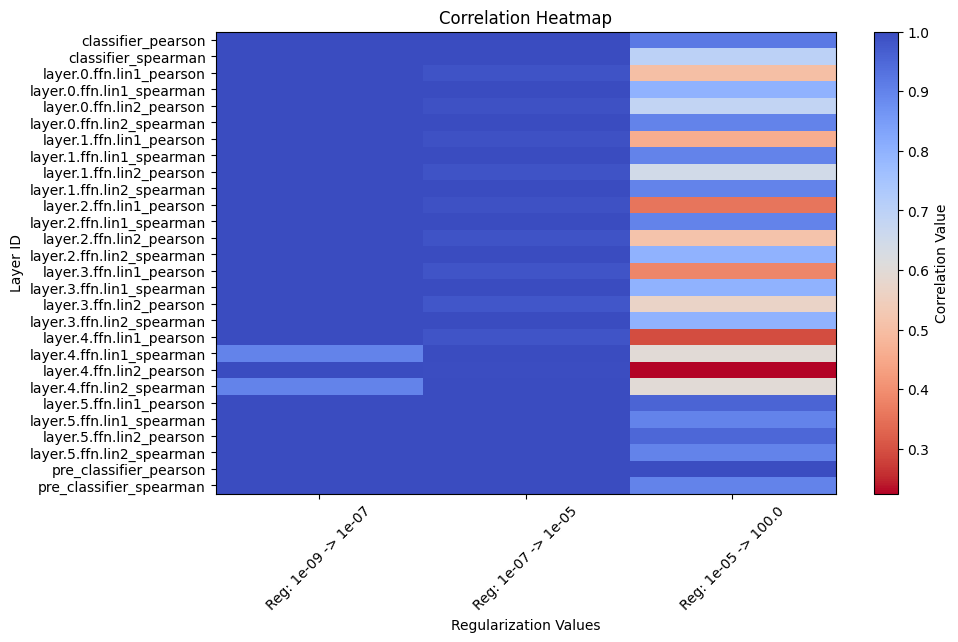

In [78]:
plt.figure(figsize=(10, 6))
plt.imshow(result_df, cmap="coolwarm_r", aspect="auto")
plt.xticks(range(result_df.shape[1]), result_df.columns, rotation=45)
plt.yticks(range(result_df.shape[0]), strip_param_names(result_df.index))
plt.colorbar(label="Correlation Value")  # Add label to the colorbar
plt.title("Correlation Heatmap")
plt.xlabel("Regularization Values")
plt.ylabel("Layer ID")
plt.show()